In [ ]:
# 1) Install lightweight extras (if missing)
!pip install -q rasterio pillow

# 2) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download the 38-Cloud dataset
path = kagglehub.dataset_download("sorour/38cloud-cloud-segmentation-in-satellite-images")
print("✅ Dataset downloaded to:", path)

# # List a few files
# !ls "$path" | head -n 20


Using Colab cache for faster access to the '38cloud-cloud-segmentation-in-satellite-images' dataset.
✅ Dataset downloaded to: /kaggle/input/38cloud-cloud-segmentation-in-satellite-images


In [ ]:
drive_destination = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud"
os.makedirs(drive_destination, exist_ok=True) # Creates the folder if it doesn't exist

# --- 3. Move the Files ---
print(f"🚚 Moving files from '{path}' to '{drive_destination}'...")
!cp -r "{path}"/* "{drive_destination}"

print("✅ All files have been successfully moved to your Google Drive!")

🚚 Moving files from '/kaggle/input/38cloud-cloud-segmentation-in-satellite-images' to '/content/drive/My Drive/Kaggle_Datasets/38-Cloud'...
✅ All files have been successfully moved to your Google Drive!


In [ ]:

# 3) Imports & device
import os, torch, traceback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [ ]:
# 4) Path to your model on Drive (change if needed)
model_path = '/content/drive/MyDrive/colab_models/best_model.pth'
print("Expecting model at:", model_path)

Expecting model at: /content/drive/MyDrive/colab_models/best_model.pth


In [ ]:
# 5) Check that file exists
if not os.path.exists(model_path):
    print("⚠️ Model file not found at the path above. Directory listing:")
    parent = os.path.dirname(model_path)
    if os.path.exists(parent):
        print(os.listdir(parent))
    else:
        print(f"Parent folder {parent} does not exist.")
    raise FileNotFoundError(f"Model not found at {model_path}")


In [ ]:

# 6) Define the UNet model (same architecture as training)
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4)
        x = self.conv1(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits


In [ ]:
# 7) Instantiate and load weights
model = UNet(n_channels=3, n_classes=1)
model = model.to(device)

try:
    # load state dict strictly first; if mismatch, will show error and we can try strict=False
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    print("✅ Model weights loaded successfully (strict=True).")
except Exception as e:
    print("⚠️ Strict load failed with error:")
    traceback.print_exc()
    print("\nTrying relaxed load (strict=False)...")
    try:
        model.load_state_dict(state, strict=False)
        print("✅ Model loaded with strict=False (some keys missing/extra).")
    except Exception as e2:
        print("✖️ Loading failed even with strict=False. See error below:")
        traceback.print_exc()
        raise e2

✅ Model weights loaded successfully (strict=True).


In [ ]:
# 8) Quick forward test using a dummy tensor to ensure shapes / CUDA working
try:
    model.eval()
    dummy = torch.randn(1, 3, 384, 384, device=device)  # adjust size if your model used different
    with torch.no_grad():
        out = model(dummy)
    print("✅ Forward test passed. Output shape:", tuple(out.shape))
    # Do not apply sigmoid here; model returns logits
except Exception as e:
    print("✖️ Forward test failed. Error:")
    traceback.print_exc()
    raise

print("\nStep 1 complete: Model is loaded and ready for inference in this notebook.")


✅ Forward test passed. Output shape: (1, 1, 384, 384)

Step 1 complete: Model is loaded and ready for inference in this notebook.


# Step 2

✅ Test dataset size: 9201 patches


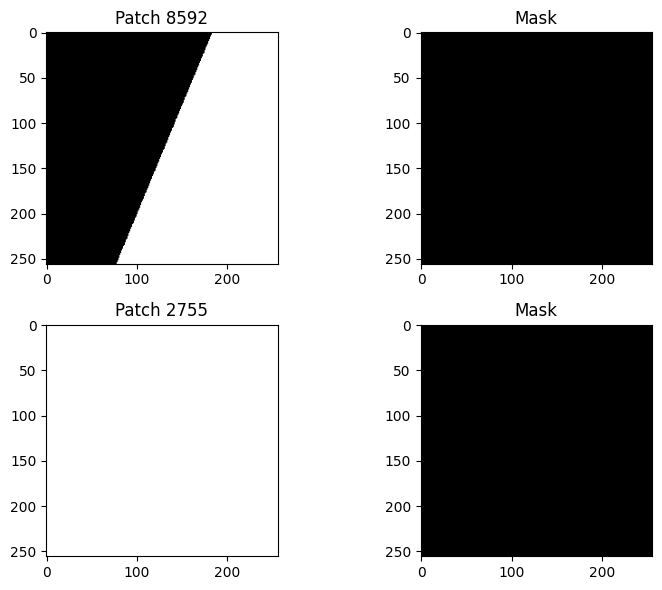

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import matplotlib.pyplot as plt

class CloudDataset4Band(Dataset):
    def __init__(self, red_dir, green_dir, blue_dir, nir_dir, mask_dir,
                 resize=(256,256)):
        self.red_dir = red_dir
        self.green_dir = green_dir
        self.blue_dir = blue_dir
        self.nir_dir = nir_dir
        self.mask_dir = mask_dir
        self.resize = resize

        # Get list of blue patch files (master list)
        self.blue_files = sorted([
            f for f in os.listdir(self.blue_dir)
            if os.path.isfile(os.path.join(self.blue_dir, f)) and f.lower().endswith('.tif')
        ])

    def __len__(self):
        return len(self.blue_files)

    def __getitem__(self, idx):
        blue_name = self.blue_files[idx]

        # Generate corresponding red/green/nir names
        red_name   = blue_name.replace('blue_patch',  'red_patch')
        green_name = blue_name.replace('blue_patch', 'green_patch')
        nir_name   = blue_name.replace('blue_patch',   'nir_patch')

        # Load four bands (16-bit)
        red   = np.array(Image.open(os.path.join(self.red_dir,   red_name)))
        green = np.array(Image.open(os.path.join(self.green_dir, green_name)))
        blue  = np.array(Image.open(os.path.join(self.blue_dir,  blue_name)))
        nir   = np.array(Image.open(os.path.join(self.nir_dir,   nir_name)))

        # Stack as float32 (H,W,4)
        img = np.stack([red, green, blue, nir], axis=-1).astype(np.float32)

        # Optional normalization (0–1)
        img = img / 65535.0  # Landsat 16-bit range

        # Resize using PIL per channel
        img_resized = []
        for c in range(img.shape[-1]):
            band_img = Image.fromarray((img[...,c]*255).astype(np.uint8))
            band_img = band_img.resize(self.resize)
            img_resized.append(np.array(band_img))
        img = np.stack(img_resized, axis=-1)  # (H,W,4)

        # Convert to torch tensor (C,H,W)
        img_tensor = torch.from_numpy(img).permute(2,0,1).float()

        # Dummy mask (no patch-level masks)
        mask = torch.zeros((1, self.resize[0], self.resize[1]), dtype=torch.float32)

        return img_tensor, mask

# ---- usage ----
RED_DIR   = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_red"
GREEN_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_green"
BLUE_DIR  = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_blue"
NIR_DIR   = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_nir"
MASK_DIR  = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/Entire_scene_gts"

test_dataset = CloudDataset4Band(RED_DIR, GREEN_DIR, BLUE_DIR, NIR_DIR, MASK_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"✅ Test dataset size: {len(test_dataset)} patches")

# Quick sanity check
idxs = random.sample(range(len(test_dataset)), 2)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, idx in enumerate(idxs):
    img, mask = test_dataset[idx]
    axes[i, 0].imshow(img[:3].permute(1,2,0))  # RGB composite
    axes[i, 0].set_title(f"Patch {idx}")
    axes[i, 1].imshow(mask.squeeze(), cmap='gray')
    axes[i, 1].set_title("Mask")
plt.tight_layout()
plt.show()


# Step 3: Custom Dataset Class

In [ ]:
# --- 0. Imports ---
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# --- 1. Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# --- 2. Dataset for RGB patches ---
class CloudRGBDataset(Dataset):
    def __init__(self, red_dir, green_dir, blue_dir, mask_dir=None):
        self.red_dir = red_dir
        self.green_dir = green_dir
        self.blue_dir = blue_dir
        self.mask_dir = mask_dir

        # List only image files
        self.red_files = sorted([f for f in os.listdir(red_dir) if f.lower().endswith(('.tif','.png','.jpg'))])
        self.green_files = sorted([f for f in os.listdir(green_dir) if f.lower().endswith(('.tif','.png','.jpg'))])
        self.blue_files = sorted([f for f in os.listdir(blue_dir) if f.lower().endswith(('.tif','.png','.jpg'))])

        print(f"Found {len(self.red_files)} red, {len(self.green_files)} green, {len(self.blue_files)} blue files.")

        assert len(self.red_files) == len(self.green_files) == len(self.blue_files), "RGB channel counts must match"

        if mask_dir:
            self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.tif','.png','.jpg'))])
            print(f"Found {len(self.mask_files)} mask files.")
            assert len(self.mask_files) == len(self.red_files), "Mask count must match RGB images"
        else:
            self.mask_files = None

    def __len__(self):
        return len(self.red_files)


    def __getitem__(self, idx):
        # Load RGB bands
        r = np.array(Image.open(os.path.join(self.red_dir, self.red_files[idx]))).astype(np.float32)
        g = np.array(Image.open(os.path.join(self.green_dir, self.green_files[idx]))).astype(np.float32)
        b = np.array(Image.open(os.path.join(self.blue_dir, self.blue_files[idx]))).astype(np.float32)

        # Stack as HxWxC
        rgb = np.stack([r,g,b], axis=-1)
        # Normalize to 0-1
        rgb = rgb / np.max(rgb)
        # Convert to tensor CxHxW
        rgb_tensor = torch.from_numpy(rgb).permute(2,0,1).float()

        if self.mask_files:
            mask = np.array(Image.open(os.path.join(self.mask_dir, self.mask_files[idx]))).astype(np.float32)
            mask_tensor = torch.from_numpy(mask).unsqueeze(0)/255.0  # 1xHxW normalized
            return rgb_tensor, mask_tensor
        else:
            return rgb_tensor, self.red_files[idx]  # return filename for saving predictions

# --- 3. Paths ---
TEST_RED_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_red"
TEST_GREEN_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_green"
TEST_BLUE_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_blue"
TEST_MASK_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/Entire_scene_gts"  # optional

print("Red files:", os.listdir(TEST_RED_DIR)[:5])
print("Green files:", os.listdir(TEST_GREEN_DIR)[:5])
print("Blue files:", os.listdir(TEST_BLUE_DIR)[:5])

Using device: cpu
Red files: ['red_patch_102_5_by_10_LC08_L1TP_064012_20160420_20170223_01_T1.TIF', 'red_patch_107_6_by_2_LC08_L1TP_035029_20160120_20170224_01_T1.TIF', 'red_patch_107_6_by_7_LC08_L1TP_003052_20160120_20170405_01_T1.TIF', 'red_patch_108_5_by_16_LC08_L1TP_064012_20160420_20170223_01_T1.TIF', 'red_patch_109_6_by_9_LC08_L1TP_032037_20160420_20170223_01_T1.TIF']
Green files: ['green_patch_101_6_by_1_LC08_L1TP_032035_20160420_20170223_01_T1.TIF', 'green_patch_101_6_by_1_LC08_L1TP_003052_20160120_20170405_01_T1.TIF', 'green_patch_103_5_by_19_LC08_L1TP_050024_20160520_20170324_01_T1.TIF', 'green_patch_103_5_by_7_LC08_L1TP_018008_20160520_20170324_01_T1.TIF', 'green_patch_103_6_by_3_LC08_L1TP_003052_20160120_20170405_01_T1.TIF']
Blue files: ['blue_patch_107_6_by_2_LC08_L1TP_029041_20160720_20170222_01_T1.TIF', 'blue_patch_109_5_by_13_LC08_L1TP_018008_20160520_20170324_01_T1.TIF', 'blue_patch_103_5_by_15_LC08_L1TP_066014_20160520_20170223_01_T1.TIF', 'blue_patch_105_5_by_21_LC08

# Step 4: Create DataLoaders

Found 9201 red, 9201 green, 9201 blue files.
Dataset size: 9201
✅ Model loaded successfully.


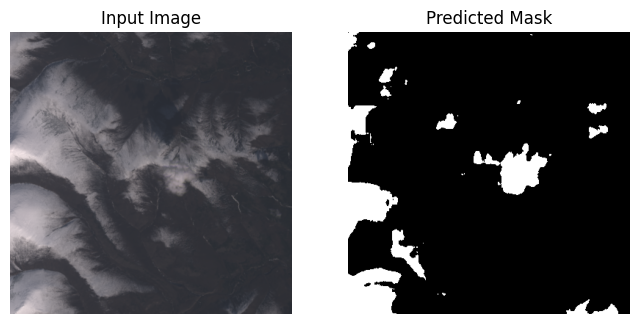

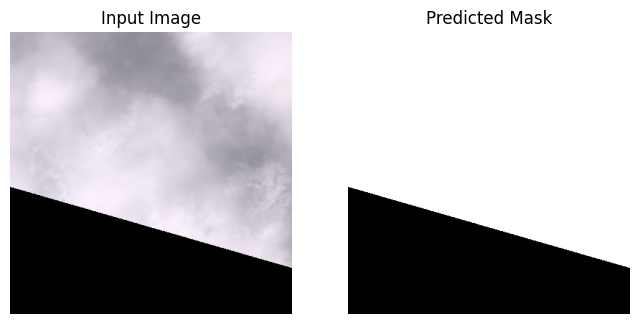

/tmp/ipython-input-2693907236.py:51: RuntimeWarning: invalid value encountered in divide
  rgb = rgb / np.max(rgb)


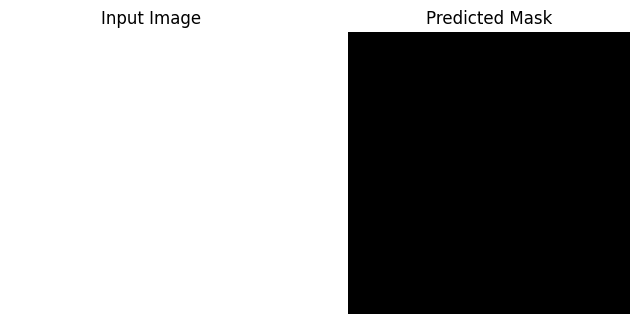

In [ ]:
# --- 4. Dataset and DataLoader ---
test_dataset = CloudRGBDataset(TEST_RED_DIR, TEST_GREEN_DIR, TEST_BLUE_DIR)
print("Dataset size:", len(test_dataset))

if len(test_dataset) == 0:
    raise ValueError("Dataset is empty! Check your folder paths.")

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- 5. Load model ---
# Replace UNet with your actual model class
model = UNet(n_channels=3, n_classes=1)
model_path = "/content/drive/MyDrive/colab_models/best_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("✅ Model loaded successfully.")

# --- 6. Visualization function ---
def visualize_predictions(model, loader, device, num_images=5):
    model.eval()
    indices = random.sample(range(len(loader.dataset)), min(num_images, len(loader.dataset)))

    for idx in indices:
        img_tensor, fname = loader.dataset[idx]
        img = img_tensor.unsqueeze(0).to(device)  # add batch dim

        with torch.no_grad():
            pred = torch.sigmoid(model(img)) > 0.5
        pred = pred.squeeze().cpu().numpy()

        # Convert image back to HWC
        img_np = img_tensor.permute(1,2,0).numpy()

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title(f"Input Image")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        plt.show()

# --- 7. Run visualization ---
visualize_predictions(model, test_loader, device, num_images=3)


# Overlays to Drive

In [ ]:

import os
import torch
from PIL import Image
import numpy as np

# --- 1. Create directories to save results ---
SAVE_MASK_DIR = "/content/drive/MyDrive/cloud_detection_project/cloud_predictions/masks"
SAVE_OVERLAY_DIR = "/content/drive/MyDrive/cloud_detection_project/cloud_predictions/overlays"

os.makedirs(SAVE_MASK_DIR, exist_ok=True)
os.makedirs(SAVE_OVERLAY_DIR, exist_ok=True)

# --- 2. Function to save masks and overlay images ---
def save_predictions(model, loader, device, save_mask_dir, save_overlay_dir):
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            # Handle datasets with/without masks
            if isinstance(batch, tuple) and len(batch) == 2:
                images, masks = batch
            else:
                images = batch
                masks = None

            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for i in range(images.size(0)):
                # Convert tensors to numpy
                img_np = images[i].cpu().permute(1,2,0).numpy()
                img_np = (img_np * 255).astype(np.uint8)

                pred_np = preds[i].cpu().squeeze().numpy()
                pred_np = (pred_np * 255).astype(np.uint8)

                # --- Save predicted mask ---
                pred_mask_img = Image.fromarray(pred_np)
                pred_mask_img.save(os.path.join(save_mask_dir, f"pred_mask_{idx}_{i}.png"))

                # --- Create overlay ---
                overlay = img_np.copy()
                # If image is grayscale, expand dims to make RGB
                if overlay.ndim == 2:
                    overlay = np.stack([overlay]*3, axis=-1)

                # Overlay mask on red channel
                overlay_img = overlay.copy()
                overlay_img[...,0] = np.clip(overlay[...,0]*0.5 + pred_np*0.5, 0, 255).astype(np.uint8)

                overlay_img = Image.fromarray(overlay_img)
                overlay_img.save(os.path.join(save_overlay_dir, f"overlay_{idx}_{i}.png"))

    print(f"✅ Predictions saved to:\nMasks: {save_mask_dir}\nOverlays: {save_overlay_dir}")

# --- 3. Run saving ---
save_predictions(model, val_loader, device, SAVE_MASK_DIR, SAVE_OVERLAY_DIR)


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2410919217.py", line 49, in __getitem__
    mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
                                            ~~~~~~~~~~~~~~~^^^^^
IndexError: list index out of range


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class CloudInferenceDataset(Dataset):
    """
    Dataset for inference: returns image tensor + filename
    """
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(img_dir)
                                   if f.lower().endswith(('.tif','.png','.jpg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.array(image)).float().permute(2,0,1)/255.0
        filename = self.image_files[idx]
        return image, filename


In [ ]:
from torchvision import transforms

img_size = 384
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

TEST_IMG_DIR = "/content/drive/My Drive/Kaggle_Datasets/38-Cloud/38-Cloud_test/test_blue"
test_dataset = CloudInferenceDataset(TEST_IMG_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"✅ Test dataset size: {len(test_dataset)} images")


✅ Test dataset size: 9201 images


In [ ]:
SAVE_MASK_DIR = "/content/drive/MyDrive/cloud_detection_project/cloud_predictions/masks"
SAVE_OVERLAY_DIR = "/content/drive/MyDrive/cloud_detection_project/cloud_predictions/overlays"
os.makedirs(SAVE_MASK_DIR, exist_ok=True)
os.makedirs(SAVE_OVERLAY_DIR, exist_ok=True)

def save_predictions(model, loader, device, save_mask_dir, save_overlay_dir):
    model.eval()
    with torch.no_grad():
        for images, filenames in loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for i in range(images.size(0)):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                img_np = (img_np*255).astype(np.uint8)

                pred_np = preds[i].cpu().squeeze().numpy()
                pred_np = (pred_np*255).astype(np.uint8)

                # Save predicted mask
                Image.fromarray(pred_np).save(os.path.join(save_mask_dir, f"mask_{filenames[i]}"))
                print(i)

                # Create overlay (semi-transparent red overlay)
                overlay = img_np.copy()
                overlay[...,0] = np.clip(overlay[...,0]*0.5 + pred_np*0.5, 0, 255).astype(np.uint8)
                Image.fromarray(overlay).save(os.path.join(save_overlay_dir, f"overlay_{filenames[i]}"))

    print(f"✅ Predictions saved to:\nMasks: {save_mask_dir}\nOverlays: {save_overlay_dir}")

save_predictions(model, test_loader, device, SAVE_MASK_DIR, SAVE_OVERLAY_DIR)



IndexError: index 4 is out of bounds for dimension 0 with size 4